# Direct Marketing Prediction

In this notebook, we are going to explore the direct marketing dataset. First, we start off with Exploratory Data Analysis, followed by feature engineering steps, walk through imputation, apply Machine Learning models, and interpret the results. We look at individual model performance, hypoerparameter tuning and look at different evaluation metrics. Later, we understand cost-benefit analysis for our problem and finally deploy a few models via. Airflow.

This notebook is solely for Data, features and model exploration, and is not the final deployment code. For more, visit [Direct Marketing Prediction Homepage](https://github.com/AdiVarma27/DirectMarketingPrediction).

#### Table Of Contents:

[Problem Statement & Data Import](#1)    
    1.1. [Problem Formulation](#1.1)    
    1.2. [Dataset import & columns exploration](#1.2)


[Exploratory Data Analysis](#2)            
    2.1. [Feature Exploration:Two-sample T-tests & Chi-square Tests](#2.1)     
    2.2. [Correlations](#2.2)       


[Feature Engineering](#3)     
    3.1. [Feature Transformation](#3.1)                  
    3.2. [Base Models](#3.2)           
   
   
[Modeling](#4)    
    4.1. [Inference Models, Logistic (L1, L2 Regularization), tuning and metrics](#4.1)         
    4.2. [ElasticNet Regressor: Grid Search, Evaluation Metrics](#4.2)            
    4.3. [Ensemble Methods](#4.3)         

---
## 1). Problem Statement & Data Import <a class="anchor" id="1"></a>

In this section, we are going to understand the task at hand and explore possible set of questions we could answer with the dataset, by looking at the columns at hand.

Our dataset comes from [UCI Repository](https://archive.ics.uci.edu/ml/datasets/bank+marketing) and original source used in the following paper:

**[A data-driven approach to predict the success of bank telemarketing](http://media.salford-systems.com/video/tutorial/2015/targeted_marketing.pdf)**

[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

### 1.1). Problem Formulation<a class="anchor" id="1.1"></a>

* From the above paper, we see that the source contains features of customers, who are **targeted through Telemarketing calls, to sell long-term deposits**. The dataset also includes calls where the client calls customer care for some reason, and long-term deposits are upsold at end of conversation as well. Hence, the dataset also contains a **label**, which denotes success or no-success on selling long-term deposits.


* The dataset comes from a real Portuguese retail bank, from May 2008 to June 2013, with 52,944 phone calls in total. As expected with real world datasets, the dataset is imbalanced (different number of successful and unsuccessful outcome of treatment effect). The author also includes other interesting external resources such as socio-economic factors (Unemployment variation) and so on. We could also look at other socia-economic metrics about Portugal for those years and see if they might influence any purchasing decision making process.


* Given we have previous campaign information (campaign, contact and outcome), we could potentially find clusters of customers (Clustered by Treatment-Response). Hence, with respect to modeling, we have clear **Supervised Learning** & **Unsupervised Learning** tasks at hand. Other than that, we have a ton of interesting questions to answer with the dataset through **Exploratory Analysis & Visualizations**. Lets start by importing the required libraries & dataset.

### 1.2). Dataset Import <a class="anchor" id="1.2"></a>

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('max_columns', None)

# importing main dataset into DataFrame
df = pd.read_csv('dataset/bank-additional/bank-additional-full.csv')

# 41k rows, 21 columns
df.shape

(41188, 21)

In [2]:
df.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Dataset Columns

##### Demographic features:
age: Age of customers (numberic)       
job: Job description (categorical)       
marital: Marital Status (categorical)       
education: Eduation level of customer (categorical)      

##### Previous behaviour:
default: has credit default ? (categorical)      
housing: has housing loan ? (categorical)        
loan: has loan ? (categorical)        

##### Previous Treatment:
contact: contact via. (categorical)         
month, day_of_week_, duration: time based features (categorical, categorical, numberic)     

##### Campaign Information:
campaign: Number of times customer was contacted in this campaign (numeric)      
pdays: Number of days since last contact of previous campaign (numeric)          
previous: Number of times customer was contacted before this campaign (numeric)      
poutcome: Outcome of previous marketing campaign (categorical)         

##### Socio-Economic features:
emp.var.rate: Employment variation rate (numeric)
cons.price.idx: Consumer price index (numeric)
cons.conf.idx: Consumer confidence index (numeric)
euribor3m: Euribor 3 mon rate (numeric)
nr.employed: Number of employees (numeric)

##### Label: y (successful purchase or not, binary outcome)

---
## 2). Exploratory Data Analysis<a class="anchor" id="2"></a>
<a class="anchor" id="2.1"></a>
<a class="anchor" id="2.2"></a>
In this section, we are going to conduct exploratory data analysis, understand distribution, correlations and analyze features across label through visualizations. A few questions which might be interesting to explore are as follows:

* Does age, job, marital status and education play a role in predicting if the customer will make the purchase ? Are they statistical differences ?

* Is previous behaviour indicative of purchasing activity ?

* Do previous campaigns show any carry over effect ? How are previous outcomes related to next outcome ?

* Do socio-economic factors play a major role ? Is there any difference across the complete time period ?

### The above questions have been answered in [EDA notebook](https://github.com/AdiVarma27/DirectMarketingPrediction/blob/master/EDA.ipynb).

In [3]:
df.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


---
## 3). Feature Engineering <a class="anchor" id="3"></a>

In this section, we are going to look at missing values imputation and developing new features. We also look at feature transformations to prep the dataset for different machine learning algorithms.


### 3.1). Feature Transformations <a class="anchor" id="3.1"></a>

First, we need to convert the label (y), from categorical variables ('yes' or 'no'), to boolean/ numeric (1/0) and rename it to 'purchased?'

In [4]:
df['purchased?'] = df['y'].apply(lambda x: 1 if x=='yes' else 0)
df.drop(columns='y', inplace=True)
df.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,purchased?
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


##### For Machine Learning algorithms such as Logistic Regression, Shallow Neural Nets, SVM, Nearest Neighbours, we need to convert non-numeric attributes into binarized vectors.


##### For Tree based algorithms such as Decision Trees, Random Forests, Bagging & Boosting classifiers, we do not need additional feature trsnformations.

First, let us start with getting dummy variables for categorical columns, and prep data (named df_encoded) for first set of Machine Learning algorithms.

In [5]:
df.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,purchased?
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [6]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
purchased?        0
dtype: int64

At first look, we see that there are no null values. From further exploration, we see that nulls have been coded as 'unknown' across all columns. Hence, let us convert them back to null.

In [7]:
df = df.replace('unknown', np.nan)
pd.DataFrame(df.isnull().sum()/len(df)).sort_values(0, ascending=False).head()

,0
default,0.208726
education,0.042027
housing,0.024036
loan,0.024036
job,0.008012


After encoding 'unknown' cells back to null, we see many missing values. Let us walk through columns iteratively and decide what to do with them.

We observe that in default column, almost 21 % of rows are unknown. We might choose to drop it based on the context. For now, let us keep it in and see how feature selection methods remove the column (if it is not predictive of the outcome).

In [8]:
# categorical variables
cat_var = df[['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 
              'day_of_week','poutcome']]

# get dummies method to return binary variables for categories across categorical columns
df_prepped_list1 = pd.get_dummies(df, cat_var.columns)

df_prepped_list1.head(2)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,purchased?,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0


### 3.2). Base Models <a class="anchor" id="3.2"></a>

#### Classifiers List 1: Logistic Regression, Knn, SVM.

Let us get the data ready to go for Base models (without any feature transformation, feature selection, hyperparameter tuning & cross-validation).

In [9]:
df.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,purchased?
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


About 11 % of dataset has label 1 and remaining label 0. Let us sample all data-points from rows with label 1 and and same number of points from rows with label 0, to balance both classes.

In [10]:
df_prepped_list1['purchased?'].sum(), len(df_prepped_list1)

(4640, 41188)

In [11]:
# concat equal sized dataframes
df_prepped_list1_model = pd.concat([df_prepped_list1[df_prepped_list1['purchased?'] == 1],  
                                    df_prepped_list1[df_prepped_list1['purchased?'] == 0].sample(4640) ])

In [12]:
len(df_prepped_list1_model)

9280

Now, let us split the dataset into train-test set (no validation dataset), into equal sizes.

In [13]:
y = df_prepped_list1_model['purchased?']
X = df_prepped_list1_model[['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_basic.4y', 'education_basic.6y', 'education_basic.9y',
       'education_high.school', 'education_illiterate',
       'education_professional.course', 'education_university.degree',
       'default_no', 'default_yes', 'housing_no', 'housing_yes', 'loan_no',
       'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr',
       'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar',
       'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',
       'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_failure', 'poutcome_nonexistent',
       'poutcome_success']]

import warnings
warnings.filterwarnings('ignore') 

In [14]:
# train test split
from sklearn.model_selection import train_test_split

# 0.5 split between train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=10)

#### Classifiers List 1: Logistic Regression, Knn, SVM.

In [15]:
# three models from List
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
nn = KNeighborsClassifier()
svm = SVC()

models = [lr, nn, svm]

train_acc = []
test_acc = []

for model in models:
    model.fit(X_train, y_train)
    train_acc.append(accuracy_score(model.predict(X_train), y_train))
    test_acc.append(accuracy_score(model.predict(X_test), y_test))

df_models1 = pd.DataFrame()
df_models1['models'] = models
df_models1['training accuracy'] = train_acc
df_models1['testing accuracy'] = test_acc

df_models1

,models,training accuracy,testing accuracy
0,LogisticRegression(),0.850000,0.854957
1,KNeighborsClassifier(),0.892241,0.854957
2,SVC(),0.820259,0.836207


Note that the above classifiers perform decently well, and have not been optimized at all (No hyper-parameter tuning, no cross validation or feature selection). We could take a look at ROC, precision-recall curves. However, we take a deeper look into them in the next section.

#### Classifiers List 2: Decision Tree, Random Forest, Boosting.

Let us repeat the same process as above, and split train-test dataset equally.

In [16]:
# three models from List
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
adb = AdaBoostClassifier()

models = [dt, rf, adb]

train_acc = []
test_acc = []

for model in models:
    model.fit(X_train, y_train)
    train_acc.append(accuracy_score(model.predict(X_train), y_train))
    test_acc.append(accuracy_score(model.predict(X_test), y_test))

df_models2 = pd.DataFrame()
df_models2['models'] = models
df_models2['training accuracy'] = train_acc
df_models2['testing accuracy'] = test_acc

df_models2

,models,training accuracy,testing accuracy
0,DecisionTreeClassifier(),1.000000,0.832328
1,"(DecisionTreeClassifier(max_features='auto', r...",1.000000,0.882974
2,"(DecisionTreeClassifier(max_depth=1, random_st...",0.880172,0.873276


---
## 4). Modeling <a class="anchor" id="4"></a>

In this section, we are going to apply few machine learning algorithms to predict customer 'purchase?' columns in the dataset. Given the use case, we are better off starting with **highly-interpretable models** for **Inference** and end up using an **Ensemble** model for production/ deployment phase.

Let us start off with **Logistic Regression**, develop new features, use feature selection techniques, see how **Lasso & Ridge Classifiers** perform along with some hyperparameter tuning & cross-validation. Later, we are going to plot ROC, precision-recall and re-tune model if necessary.

### 4.1). Inference Modeling <a class="anchor" id="4.1"></a>

Let us start off by building a base-model for **Logistic Regression**, and work our way into fine-tuning it further. Here is our basic base model with balanced dataset. Let us look at feature correlations are removed highly correlated features.

In [17]:
corr = X.corr().abs()
corr.sum().sort_values().tail()

contact_telephone       7.717217
poutcome_nonexistent    8.129726
emp.var.rate            9.787550
nr.employed             9.827747
euribor3m               9.913350
dtype: float64

###### euribor3m feature

In [18]:
X.corr()['euribor3m'].sort_values().head()

previous           -0.452857
contact_cellular   -0.439331
poutcome_success   -0.372385
poutcome_failure   -0.303880
default_no         -0.268489
Name: euribor3m, dtype: float64

In [19]:
X.corr()['euribor3m'].sort_values().tail()

cons.price.idx    0.565952
nr.employed       0.941043
emp.var.rate      0.958247
euribor3m         1.000000
default_yes            NaN
Name: euribor3m, dtype: float64

We observe that 'euribor3m' is extremely highly correlated with nr.employed & emp.var.rate. Hence, we delete this columns from our dataset. Next, let us take a look at 'nr.employed' feature.

###### nr.employed

In [20]:
X.corr()['nr.employed'].sort_values().head()

previous           -0.529913
poutcome_success   -0.450210
contact_cellular   -0.334308
month_sep          -0.318336
poutcome_failure   -0.275867
Name: nr.employed, dtype: float64

In [21]:
X.corr()['nr.employed'].sort_values().tail()

poutcome_nonexistent    0.544654
emp.var.rate            0.867840
euribor3m               0.941043
nr.employed             1.000000
default_yes                  NaN
Name: nr.employed, dtype: float64

We can also remove 'nr.employed' as it is highly correlated with 'emp.var.rate'. Now, let us look at 'emp.var.rate'.

###### emp.var.rate

In [22]:
X.corr()['emp.var.rate'].sort_values().head()

contact_cellular   -0.422213
previous           -0.384517
poutcome_success   -0.322400
poutcome_failure   -0.297483
default_no         -0.269575
Name: emp.var.rate, dtype: float64

In [23]:
X.corr()['emp.var.rate'].sort_values().tail()

cons.price.idx    0.716511
nr.employed       0.867840
euribor3m         0.958247
emp.var.rate      1.000000
default_yes            NaN
Name: emp.var.rate, dtype: float64

We already removed columns where 'emp.var.rate' is highly correlated with. Hence, we need not drop this column.

Now, let us check correlation for 'contact_cellular'.

###### contact_cellular

In [24]:
X.corr()['contact_cellular'].sort_values().head()

contact_telephone   -1.000000
cons.price.idx      -0.489447
euribor3m           -0.439331
emp.var.rate        -0.422213
nr.employed         -0.334308
Name: contact_cellular, dtype: float64

In [25]:
X.corr()['contact_cellular'].sort_values().tail()

poutcome_failure    0.175490
previous            0.212629
month_aug           0.212825
contact_cellular    1.000000
default_yes              NaN
Name: contact_cellular, dtype: float64

#### We got rid of highly correlated features. Let us now take a look at the heatmap for correlation, after dropping the columns. 

In [26]:
df_prepped_list1.drop(columns=['euribor3m', 'nr.employed'], inplace=True)

In [27]:
df_prepped_list1.corr().abs().sum().sort_values().tail()

poutcome_nonexistent    6.897032
cons.price.idx          7.027162
contact_telephone       7.356957
contact_cellular        7.356957
emp.var.rate            8.110165
dtype: float64

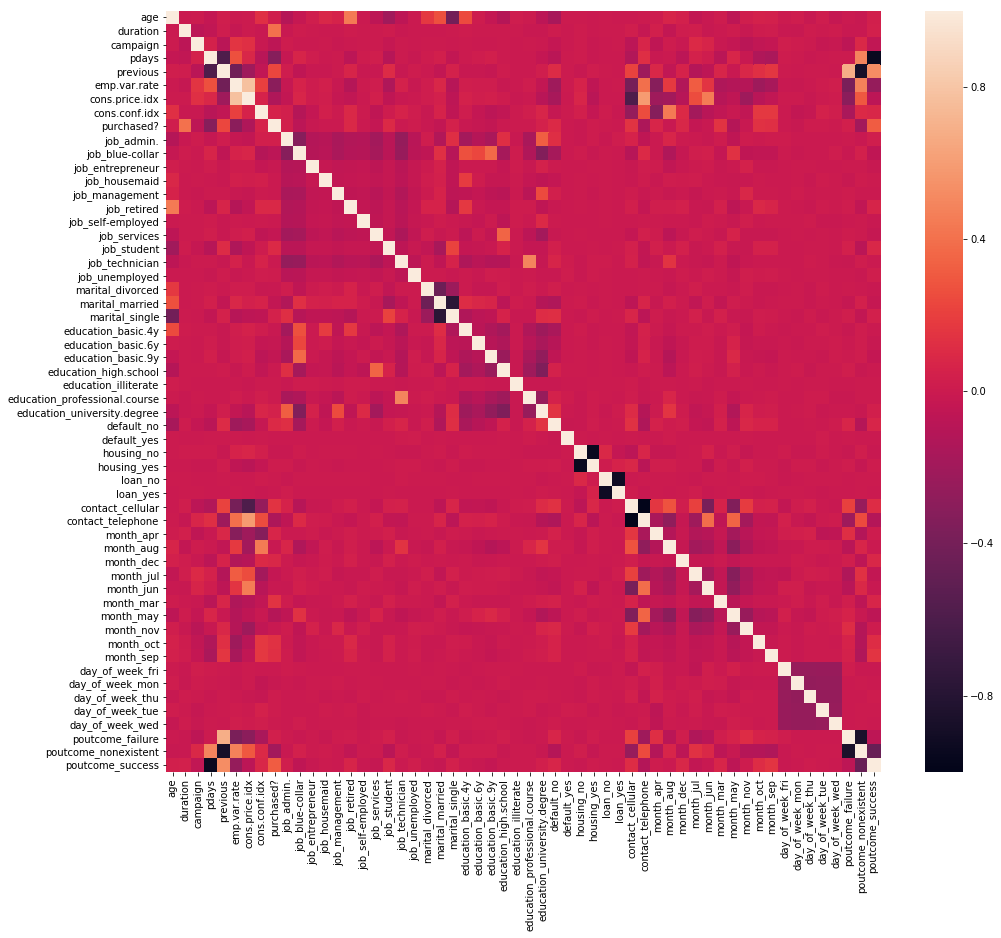

In [28]:
plt.figure(figsize=(16,14))
sns.heatmap(df_prepped_list1.corr(), annot=False)

We might want to check for 'pdays' & 'poutcome_success', to drop one of the columns.

In [29]:
df_prepped_list1.corr()['pdays'].sort_values().head()

poutcome_success   -0.950700
previous           -0.587514
purchased?         -0.324914
month_sep          -0.154629
month_oct          -0.128677
Name: pdays, dtype: float64

In [30]:
df_prepped_list1.corr()['pdays'].sort_values().tail()

cons.price.idx          0.078889
contact_telephone       0.117970
emp.var.rate            0.271004
poutcome_nonexistent    0.491353
pdays                   1.000000
Name: pdays, dtype: float64

In [31]:
df_prepped_list1.corr()['poutcome_success'].sort_values().head()

pdays                  -0.950700
poutcome_nonexistent   -0.466928
emp.var.rate           -0.256886
contact_telephone      -0.111934
cons.price.idx         -0.077416
Name: poutcome_success, dtype: float64

In [32]:
df_prepped_list1.corr()['poutcome_success'].sort_values().tail()

month_oct           0.115812
month_sep           0.149349
purchased?          0.316269
previous            0.524045
poutcome_success    1.000000
Name: poutcome_success, dtype: float64

Let us go ahead and also remove 'pdays' column from our dataset.

In [33]:
df_prepped_list1.drop(columns=['pdays'], inplace=True)

Now that we have removed highly correlated features, let us start by applying a Logistic regression Model.

### Timeline

An important feature we need to transform is the month. We know that our dataset contains month column, but does not have an year associated to it. If we directly transform the columns month to dummy variable, we lose the effect of it belonging to a specific year.

Let us explore and see if the dataframe is formatted in order of time.

In [34]:
df_prepped_list1.shape, df.shape

((41188, 55), (41188, 21))

In [35]:
df_prepped_list1['month'] = df['month']

##### It would be interesting to see purchased? label across months. Note how we see that across aug, jul, may & nov, the label column is less than 10 %. 

##### However, the columns below are for months aggregated across multiple years, we need to generate a transformed column and check for months across different years to understand whats really going on.

In [36]:
df_prepped_list1.groupby(['month']).mean()['purchased?']

month
apr    0.204787
aug    0.106021
dec    0.489011
jul    0.090466
jun    0.105115
mar    0.505495
may    0.064347
nov    0.101439
oct    0.438719
sep    0.449123
Name: purchased?, dtype: float64

Now, we start with year1, and add the string, so that we know the year_month combination for each row of our dataset.

In [37]:
# below python code checks for december and increments the current year

month_list = df_prepped_list1['month'].tolist()
updated_list = ['1_may']
curr_year = 1

for i in range(0,len(month_list)-1):
    curr_mon = month_list[i]
    next_mon = month_list[i+1]
    
    if curr_mon == 'dec' and next_mon != 'dec':
        curr_year += 1
    
    updated_list.append(str(curr_year) + '_' + next_mon)

In [38]:
len(updated_list), len(df_prepped_list1)

(41188, 41188)

In [39]:
df_prepped_list1['mon_year'] = updated_list

# delete previous mon and day of week columns
df_prepped_list1.drop(columns=['month_apr', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu',
       'day_of_week_tue', 'day_of_week_wed', 'month'], inplace=True)

# get dummies for new column
df_prepped_list1 = pd.get_dummies(df_prepped_list1, 'mon_year')

In [40]:
# concat equal sized dataframes
df_prepped_list1_model = pd.concat([df_prepped_list1[df_prepped_list1['purchased?'] == 1],  
                                    df_prepped_list1[df_prepped_list1['purchased?'] == 0].sample(4640) ])

y = df_prepped_list1_model['purchased?']
X = df_prepped_list1_model[['age', 'duration', 'campaign', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'education_basic.4y',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'default_no', 'default_yes',
       'housing_no', 'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'poutcome_failure', 'poutcome_nonexistent',
       'poutcome_success', 'mon_year_1_aug', 'mon_year_1_dec',
       'mon_year_1_jul', 'mon_year_1_jun', 'mon_year_1_may', 'mon_year_1_nov',
       'mon_year_1_oct', 'mon_year_2_apr', 'mon_year_2_aug', 'mon_year_2_dec',
       'mon_year_2_jul', 'mon_year_2_jun', 'mon_year_2_mar', 'mon_year_2_may',
       'mon_year_2_nov', 'mon_year_2_oct', 'mon_year_2_sep', 'mon_year_3_apr',
       'mon_year_3_aug', 'mon_year_3_jul', 'mon_year_3_jun', 'mon_year_3_mar',
       'mon_year_3_may', 'mon_year_3_nov', 'mon_year_3_oct', 'mon_year_3_sep']]

# 0.5 split between train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=10)

In [41]:
from sklearn.linear_model import LogisticRegression  

# Logistic Regression
lr1 = LogisticRegression()
lr1.fit(X_train, y_train)
y_pred = lr1.predict(X_test)

# testing accuracy
accuracy_score(y_pred, y_test)

0.8603448275862069

Now, let us take a look at how we can transform existing features and also develop new features. Before that, let us take a look at interpreting our base model1. To do so, we need to look at coefficients of the model and interpret them. Let us look at the log-odds, convert them to odds and see how each coefficient contributes to prediction.


Let us take a look at the t-stats, p-value for each variable & also R-squared for Logistic Model.

In [42]:
df_feat = pd.DataFrame()
df_feat['features'] = ['intercept_term'] + X.columns.tolist()
df_feat['beta'] = [lr1.intercept_] + lr1.coef_[0].tolist()
df_feat.loc[0, 'beta'] = df_feat.iloc[0].beta[0]
df_feat['beta'] = pd.to_numeric(df_feat['beta'])
df_feat['odds'] = np.exp(df_feat.beta)
df_feat['odds'] = df_feat['odds'].astype('str')


# top 5 features in descending order of odds
df_feat.sort_values('odds', ascending=False).head()

,features,beta,odds
39,poutcome_success,0.810729,2.2495465187326875
4,previous,0.512119,1.6688228736237902
29,default_no,0.391474,1.4791587841287186
52,mon_year_2_mar,0.333581,1.3959581336491276
28,education_university.degree,0.314508,1.369585055605731


In [43]:
# top 5 features in ascending order of odds
df_feat.sort_values('odds', ascending=True).head()

,features,beta,odds
53,mon_year_2_may,-1.161832,0.3129124526294916
5,emp.var.rate,-0.790922,0.4534265475547675
37,poutcome_failure,-0.778708,0.45899866191602495
44,mon_year_1_may,-0.510099,0.6004360647472782
9,job_blue-collar,-0.425278,0.6535880241451834


## Inference 

Let us look at the top 10 (5 highest and 5 least Odd Ratios) in our Inference Model. We know that Logistic Regression models is defined such that the coefficient value corresponds to **Log-Odds**, and needs to be converted back to the **Odds-Ratio** for each feature.

* From the first table, we see that **'poutcome_success'has odds ratio of 2**, which is extremely high. Hence, Outcome of previous marketing campaign is a strong predictor of purchasing (and makes intuitive sense).


* We see that **'previous' variable has odds of 1.8** (Number of times customer was contacted before this campaign), which makes sense. These could be high-value customers and we always need to keep in contact with them.


* We also observe that **'education_university.degree' column has odds of 1.5 and 'default_no' has odds of 1.45**   (highly educated and customers with no default are more likely to purchase, which makes intuitive sense).


* From table two, we observe that **'mon_year_2_may' has extremely low odds (0.38), which we need to further investigate into. (Could potentially be a market trend).**


* We see that **'emp.var.rate' & 'poutcome_failure'** have around 0.5 odds. We need to see the 'emp.var.rate' for May of year 2 and see if they are related. 


* **'job_blue-collar'** column has low odds, as customers in that description may not have high-savings and might opt other investment options.


**All the above insights are extremely strong indicators of potential customers for our long-term investment product.**

### Ridge & ElasticNet Regression Models

In [44]:
from sklearn.linear_model import RidgeClassifier

lr_ridge = RidgeClassifier()
lr_ridge.fit(X_train, y_train)
y_pred_ridge = lr_ridge.predict(X_test)

# 85 % accuracy
accuracy_score(y_test, y_pred_ridge)

0.8446120689655172

Let us now tune for a range of 'alpha', and large values of alpha correspond to high regularization effect.

In [45]:
alpha_params = np.arange(0.1, 4, 0.5)
alpha_params

array([0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6])

In [46]:
acc = {}
for alpha in alpha_params:
    lr_ridge = RidgeClassifier(alpha=alpha)
    lr_ridge.fit(X_train, y_train)
    y_pred_ridge = lr_ridge.predict(X_test)

    # 85 % accuracy
    acc[alpha] = accuracy_score(y_test, y_pred_ridge)

In [47]:
acc

{0.1: 0.8439655172413794,
 0.6: 0.8441810344827586,
 1.1: 0.8448275862068966,
 1.6: 0.8448275862068966,
 2.1: 0.8448275862068966,
 2.6: 0.8448275862068966,
 3.1: 0.8448275862068966,
 3.6: 0.8450431034482758}

We observe that the model is fairly stable for any range of alpha values. Let us now try ElasticNet regressor and see how we including feature selection step can help improve model performance.


In case of ElasticNet Regressor, we can tune l1 to l2 ratio as well as alpha. Let us look at the official documentation and see we can **control individually for L1, L2 and ratio of L1, L2** as well.

---
<a class="anchor" id="4.2"></a>

## ElasticNet Regressor: Grid Search, Evaluation Metrics

#### Documentation 
###### Source: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

If you are interested in controlling the L1 and L2 penalty separately, keep in mind that this is equivalent to:

a * L1 + b * L2

where:

alpha = a + b and l1_ratio = a / (a + b)

In [48]:
# we select a wide range for both parameters and use gridsearch with cv=5

param_grid = [
  {'alpha': np.arange(0.01, 4, 0.5), 
   'l1_ratio': np.arange(0.1, 1, 0.1)},
 ]

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

lr_elasticnet = ElasticNet()
search = GridSearchCV(lr_elasticnet, param_grid, cv=5)

search.fit(X, y)

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid=[{'alpha': array([0.01, 0.51, 1.01, 1.51, 2.01, 2.51, 3.01, 3.51]),
                          'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])}])

In [50]:
# best parameters
search.best_params_

{'alpha': 0.01, 'l1_ratio': 0.6}

We observe that best parameters are at l1_ratio = 0.5, meaning equal importance to both **Lasso & Ridge Regularization**.

In [61]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(alpha=0.01, penalty='elasticnet')
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.01, penalty='elasticnet')

In [63]:
# 85 % accuracy
y_pred = sgd_clf.predict(X)
accuracy_score(y, y_pred)

0.8488146551724138

### Evaluation Metrics

Let us first take a look at the confusion matrix, and understand which error might be important in our context.